# ----------------------------- Machine Learning Avancé ---------------------------

### --------------------------------------        Exercice de classification     --------------------------------------

#### DISCLAIMER 
Il faut passer sous l'environnement new_env pour que les bibliothèques fonctionnent (en particulier img_aug pour la data augmentation).

'conda activate new_env'
'jupyter notebook --ResourceUseDisplay.mem_limit=1024'

#### Contexte
Il s’agit d’un problème de classification d’images de visages. Le critère de classification n’est pas décrit ici, il est défini de façon implicite par les labels de la base d’apprentissage.

#### Data
Les données sont les suivantes :
- Une base : 122670 images de visage, numérotée de 000001 à 122670. Les fichiers sont au format jpg, les images font 130x130 et sont en couleur.
- La liste d’apprentissage : un fichier nommé « esiea_train_2022_DL.txt », contenant 102670 lignes de la forme « Nom_d’image label_associé (-1 ou 1) »
- La liste de test : un fichier nommé « esiea_valid_2022_DL.txt », contenant 20000 lignes de la forme : « Nom_d’image »

#### Résultats attendus
- La métrique retenue est la moyenne des erreurs sur chaque classe. Notez que le nb d’élément dans chaque classe est différent. Cela devra être pris en compte dans les apprentissages pour des performances optimales
- J’ai volontairement bruité un faible pourcentage des labels. Une loss robuste pourrait aider lors de l’apprentissage.
- Il est demandé aux étudiants de fournir les prédictions du jeu de test pour l’évaluation, sous forme de fichier texte, nommé « Nom_d’image predictions_nom1_nom2.txt », d’exactement 20000 lignes, au même format que le fichier de liste d’apprentissage mais pour la liste de la base de test (en respectant l’ordre des images de la liste « esiea_valid_2022_DL.txt ».

#### Documents attendus
- Il est demandé aux étudiants de fournir le modèle appris, le code python/tensorflow/pytorch/keras ayant servi à apprendre le modèle ainsi qu’un code python permettant de générer « predictions_nom1_nom2.txt » à partir du modèle.
- Questions.

#### Questions  :
1. Quel type d’architecture avez-vous utilisé, pourquoi ?
2. Combien de convolutions contient votre architecture, pourquoi ?
3. Comment vous êtes-vous préoccupé de l’over-fitting ?
4. Est-ce que l’asymétrie de la base d’apprentissage est un problème ? si oui, comment avez traité ?
5. Est-ce que les labels bruités ont posé problème. Comment l’avez-vous géré ?
6. Pour les images de la base de test, à partir de la sortie de votre réseau, comment attribuez-vous le label ?
7. Avec un mois supplémentaire pour travailler, que feriez-vous pour améliorer vos résultats ?
8. Question non notée : A quoi correspond le label recherché ?

In [1]:
#imports
import pandas as pd
import numpy as np

import torchvision
import torch

import matplotlib.pyplot as plt
from matplotlib.image import imread

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from IPython.display import display, Image
from IPython.core.display import HTML 

import imgaug as ia
import imgaug.augmenters as iaa

from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import datasets, layers, models
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import normalize
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.regularizers import l2


import os
import cv2
from PIL import Image
import random

## Observation de nos données :

Il est intéressant de voir à quoi ressemble de nos données avant de commencer à les traiter.

- Nous avons un dossier de 122670 images dont 102670 sont nos données d'entraînement labellisées. Les 20 000 restantes sont nos images de validation

Pour les observer une à une, nous pouvons passer un tenseur.
On stocke nos images dans une seule variable pour faire du Deep Learning : ce type de variable contenant plusieurs images sous formes de tenseur est appelé un lot d’image, un batch.

Un tenseur est un tableau multidimensionnel.
Pour les réseaux de neurones et a fortiori le Deep Learning, les données et les résultats des calculs sont représentés par des tenseurs.
Par exemple, une image en niveaux de gris est un tenseur 2D, une image couleur un tenseur 3D.

On utilise la fonction torchvision.io.read_image() pour charger notre image dans un tenseur : c'est intéressant afin de voir la dimension de quelques images.

In [2]:
#on charge quelques images pour les étudier
tsr_img = torchvision.io.read_image('C:/Users/sarah/OneDrive/Bureau/5A/Machine Learning Avancé/img_esiea/000001.jpg')
tsr_img.shape

torch.Size([3, 130, 130])

3 représentant la dimension couleur, 130 la largeur et 130 la hauteur.

Si l’on veut afficher notre image avec matplotlib on devra transformer le format de l’image de (3, 130, 130) en (130, 130, 3).

Pour cela on utilise la fonction permute() qui nous permet de déplacer les dimensions d’un tenseur.

Une fois que c’est fait on peut afficher notre image !

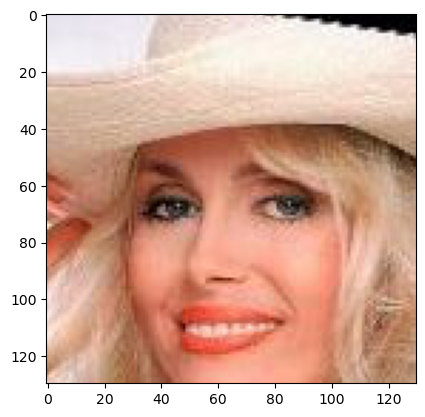

In [3]:
plt.imshow(tsr_img.permute((1,2,0)))

## I. Préparation des données

### 1. Chargement des données

Nous allons commencer par lire le nom des images de validation (celles dont on doit prédire les labels à la fin), et des images d'entraînement pour les distinguer.

In [4]:
label_img_valid = pd.read_csv("C:/Users/sarah/OneDrive/Bureau/5A/Machine Learning Avancé/esiea_valid_2022_DL.txt", sep=" ", header=None)
label_img_valid.columns = ['Nom image']
label_img_valid #images de test

,Nom image
0,078875.jpg
1,054206.jpg
2,039464.jpg
3,088046.jpg
4,114912.jpg
...,...
19995,097212.jpg
19996,050387.jpg
19997,049930.jpg
19998,054650.jpg


In [5]:
label_img_train = pd.read_csv("C:/Users/sarah/OneDrive/Bureau/5A/Machine Learning Avancé/esiea_train_2022_DL.txt", sep=" ", header=None)
label_img_train.columns = ['Nom image', 'Label']
label_img_train #images de train avec leur label

,Nom image,Label
0,000002.jpg,1
1,000004.jpg,1
2,000005.jpg,1
3,000006.jpg,1
4,000007.jpg,1
...,...,...
102665,122666.jpg,1
102666,122667.jpg,1
102667,122668.jpg,1
102668,122669.jpg,-1


### 2. Equilibre de classes

#### Intéressons nous à l'équilibre de classes :

In [6]:
label_img_train["Label"].value_counts()

 1    69086
-1    33584
Name: Label, dtype: int64

Nous remarquons qu'il y a 2 fois plus de classe 1 que de classe -1, ce qui est embêtant car notre modèle apprendra donc bien à distinguer une classe que l'autre.

#### Nous faisons face à des soucis de mémoire qui nous empêchent de traiter toutes les images de train, nous allons donc échantillonner en prenant 20 000 images du label 1 et 10 000 images du label -1 pour reproduire le phénomène de déséquilibre à échelle moindre.

In [7]:
#nom d'image label 1
img_lab1 = label_img_train[label_img_train['Label'] == 1]
nom_img_lab1 = list(img_lab1['Nom image'])
nom_img_lab1 = random.choices(nom_img_lab1, k=10000) #on en choisit 5000 au hasard

#nom d'image label -1
img_lab0 = label_img_train[label_img_train['Label'] == -1]
nom_img_lab0 = list(img_lab0['Nom image'])
nom_img_lab0 = random.choices(nom_img_lab0, k=5000) #on en choisit 2500 au hasard

print(len(nom_img_lab1))
print(len(nom_img_lab0))

10000
5000


In [8]:
#on ajoute tous les noms d'image dans une liste 
for elem in nom_img_lab0:
    nom_img_lab1.append(elem)
    
print(len(nom_img_lab1))    

15000


In [9]:
#on crée le nouveau dataframe associé à ce découpage
df_train = pd.DataFrame()

#on remplit le dataframe de 0 sinon on a des problèmes d'indexage en remplissant
for i in range(len(nom_img_lab1)):
    df_train.loc[i, 'Nom image'] = 0
    df_train.loc[i, 'Label'] = 0

for i in range(len(nom_img_lab1)):
    df_train.loc[i, 'Nom image'] = nom_img_lab1[i]
    df_train.loc[i, 'Label'] = label_img_train[label_img_train['Nom image'] == nom_img_lab1[i]].iloc[0,1] #on remplit avec le bon label associé à l'image

In [10]:
df_train

,Nom image,Label
0,056470.jpg,1.0
1,121063.jpg,1.0
2,017804.jpg,1.0
3,063407.jpg,1.0
4,040122.jpg,1.0
...,...,...
14995,025775.jpg,-1.0
14996,101544.jpg,-1.0
14997,037197.jpg,-1.0
14998,076401.jpg,-1.0


### 3. Data Augmentation

Pour rémédier à ce problème d'asymétrie des classes, nous faisons une data augmentation qui va dupliquer chaque image du label -1 en y effectuant une transformation.

#### Techniques de Data Augmentation 
Nous pouvons appliquer diverses modifications aux données initiales. Par exemple, pour les images, nous pouvons utiliser :

- Des transformations géométriques : vous pouvez retourner, recadrer, faire pivoter ou translater des images de façon aléatoire, et ce n'est que la pointe de l'iceberg.
- Transformations de l'espace couleur : modifiez les canaux de couleur RVB, intensifiez n'importe quelle couleur.
- Filtres à noyaux : pour rendre une image plus nette ou plus floue. 
- Effacement aléatoire : supprimer une partie de l'image initiale
- Mélange d'images : il s'agit essentiellement de mélanger des images entre elles. C'est peut-être contre-intuitif, mais ça marche.

In [11]:
#data augmentation pour nos images où label = -1
image_aug = []

for i in range(len(nom_img_lab0)):
    image = imread("C:/Users/sarah/OneDrive/Bureau/5A/Machine Learning Avancé/img_esiea/"+ nom_img_lab0[i]) #on les récupère
    image_aug.append(np.array(image))

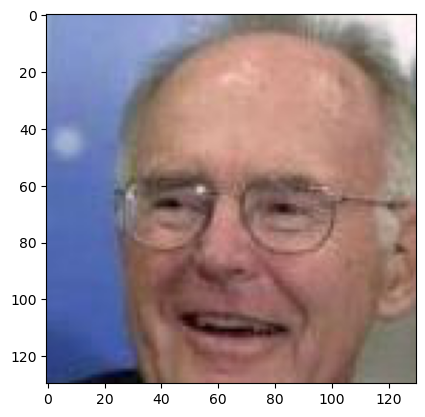

In [12]:
plt.imshow(image_aug[6]) #image de base (label -1)

In [13]:
images = image_aug #on récupère nos images de base avec label = -1
seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.2)]) #on crée une séquence de transformation
images_aug = seq(images=images) #on récupère nos images transformées

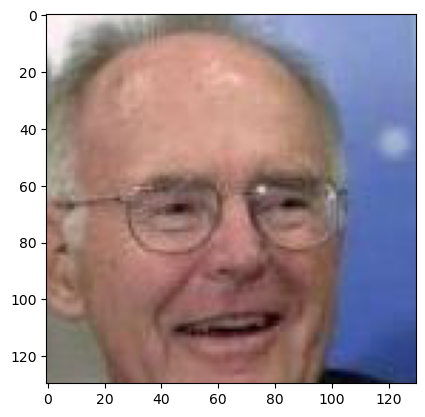

In [14]:
plt.imshow(images_aug[6]) #image transformée

In [15]:
#on récupère nos images de train
images_train = []

for i in range(len(nom_img_lab1)):
    image = imread("C:/Users/sarah/OneDrive/Bureau/5A/Machine Learning Avancé/img_esiea/"+ nom_img_lab1[i])
    images_train.append(np.array(image))

In [16]:
#on ajoute nos images augmentées à nos images de train
for i in range(len(images_aug)):
    image = images_aug[i]
    images_train.append(np.array(image))

In [17]:
print(len(images_train))
print(type(images_train[0]))
print(type(images_train))

20000
<class 'numpy.ndarray'>
<class 'list'>


In [18]:
#on ajoute nos images augmentées au df de base 
df_aug = pd.DataFrame(columns = ['Nom image', 'Label'])

for i in range(len(nom_img_lab0)):
    df_aug.loc[i, 'Nom image'] = "aug-" + nom_img_lab0[i]
    df_aug.loc[i, 'Label'] = -1

In [19]:
import warnings
warnings.filterwarnings('ignore')

#on ajoute ce df au fichier de base
df_train = df_train.append(df_aug,ignore_index=True)

In [20]:
df_train

,Nom image,Label
0,056470.jpg,1.0
1,121063.jpg,1.0
2,017804.jpg,1.0
3,063407.jpg,1.0
4,040122.jpg,1.0
...,...,...
19995,aug-025775.jpg,-1
19996,aug-101544.jpg,-1
19997,aug-037197.jpg,-1
19998,aug-076401.jpg,-1


In [21]:
df_train["Label"].value_counts() #on compte le nombre d'occurences pour chacune des classes #c'est réglé

 1.0    10000
-1.0    10000
Name: Label, dtype: int64

#### Le problème d'équilibre de classes est réglé !

Pour des raisons de performances de l'algorithme du modèle et de ses fonctions d'activation (relu), on transforme nos label -1 en 0.

In [22]:
#on change les labels -1 en 0
df_train["Label"] = df_train["Label"].replace(-1, 0)

In [23]:
df_train

,Nom image,Label
0,056470.jpg,1.0
1,121063.jpg,1.0
2,017804.jpg,1.0
3,063407.jpg,1.0
4,040122.jpg,1.0
...,...,...
19995,aug-025775.jpg,0.0
19996,aug-101544.jpg,0.0
19997,aug-037197.jpg,0.0
19998,aug-076401.jpg,0.0


In [24]:
df_train["Label"].value_counts()

1.0    10000
0.0    10000
Name: Label, dtype: int64

In [25]:
#on extrait les labels
label = list(df_train['Label'])
print(type(label))

<class 'list'>


In [26]:
#on convertit en np.array
dataset = np.array(images_train)
label = np.array(label)

In [27]:
print(type(dataset))
print(type(label))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [28]:
#on split les données en train/validation (=test)

X_train, X_test, y_train, y_test = train_test_split(images_train, label, test_size = 0.20, random_state = 0)

In [29]:
#on normalise nos images

X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

## II. Le modèle

<img src="https://editor.analyticsvidhya.com/uploads/63131flowchart%20data%20split.png" width=500 height=500 />

#### CONTEXTE :
Nous sommes dans une classification BINAIRE.

In [30]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5,5), activation="relu", input_shape=(130, 130, 3))) 
#relu car label 0 ou 1 (tanh 1 ou -1)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2)) #éviter sur-apprentissage

model.add(Conv2D(filters=32, kernel_size=(5,5), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5,5), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(5,5), activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.001)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.add(Flatten())

model.compile(loss='binary_crossentropy',optimizer ='RMSprop' ,metrics=['accuracy']) #optimizer = 'Adam' #adaptive learning rate

#il ne faut pas utiliser softmax pour la classification binaire, elle est plus intéressante pour les problèmes multiclasses
#mutuellement exclusives où chaque classe a une probabilité et la plus grande gagne

#les sorties de la fonction Sigmoid sont des probabilités
#bien pour les problèmes binaires mutuellement exclusifs (chat ou pas chat)

In [32]:
result = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
500/500 [==============================] - 2050s 4s/step - loss: 0.6312 - accuracy: 0.7065 - val_loss: 0.7583 - val_accuracy: 0.6018
Epoch 2/20
500/500 [==============================] - 1959s 4s/step - loss: 0.4154 - accuracy: 0.8298 - val_loss: 0.3516 - val_accuracy: 0.8622
Epoch 3/20
500/500 [==============================] - 1951s 4s/step - loss: 0.3512 - accuracy: 0.8602 - val_loss: 0.3736 - val_accuracy: 0.8482
Epoch 4/20
500/500 [==============================] - 1956s 4s/step - loss: 0.3160 - accuracy: 0.8749 - val_loss: 0.3751 - val_accuracy: 0.8375
Epoch 5/20
500/500 [==============================] - 1950s 4s/step - loss: 0.2886 - accuracy: 0.8889 - val_loss: 0.3888 - val_accuracy: 0.8453
Epoch 6/20
500/500 [==============================] - 1939s 4s/step - loss: 0.2715 - accuracy: 0.8947 - val_loss: 0.3074 - val_accuracy: 0.8802
Epoch 7/20
500/500 [==============================] - 1962s 4s/step - loss: 0.2519 - accuracy: 0.9087 - val_loss: 0.3247 - val_accuracy:

In [33]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

125/125 [==============================] - 167s 1s/step - loss: 0.3065 - accuracy: 0.9065
Accuracy =  90.6499981880188 %


In [ ]:
#model.save("result.h5py") #si on veut save le modèle

In [46]:
proba = model.predict(X_test)

proba[proba <= 0.5] = 0 #si la proba est < 50% 
proba[proba > 0.5] = 1 #si la proba est > 50% 

125/125 [==============================] - 166s 1s/step


In [47]:
print(len(proba))
print(len(y_test))

4000
4000


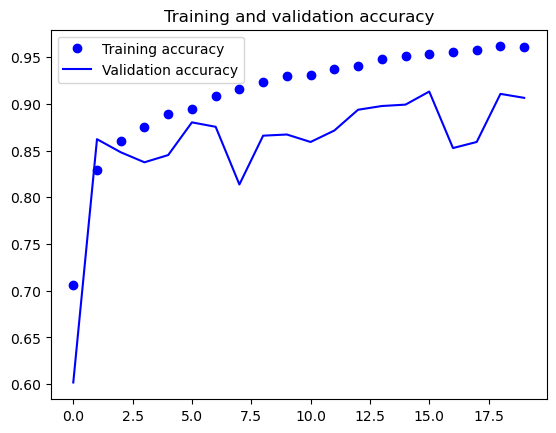

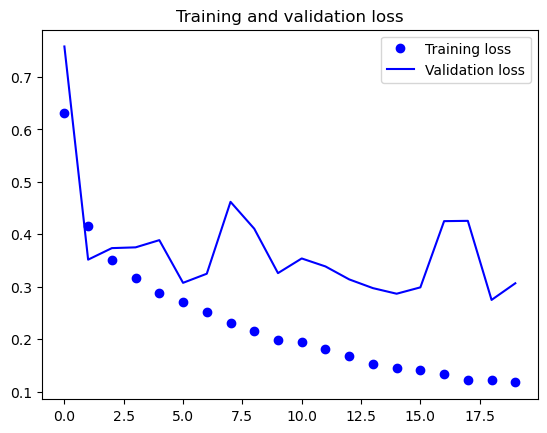

In [48]:
accuracy = result.history['accuracy']
val_accuracy = result.history['val_accuracy']
loss = result.history['loss']
val_loss = result.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [49]:
cm=confusion_matrix(y_test, proba)  
print(cm)

[[1855  151]
 [ 223 1771]]


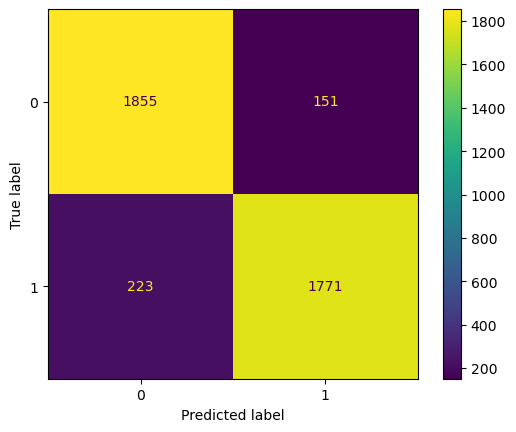

In [50]:
confusion_matrix = metrics.confusion_matrix(y_test, proba)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [51]:
correct = 0
for i in range(len(y_test)):
    if y_test[i] == proba[i]:
        correct += 1
        
incorrect = len(y_test) - correct

print("Labels trouvés corrects :", (correct/len(y_test)*100), "%, ce qui correspond à :", correct, "labels.")
print("Labels trouvés incorrects :", 100-(correct/len(y_test)*100), "%, ce qui correspond à :", incorrect, "labels.")

Labels trouvés corrects : 90.64999999999999 %, ce qui correspond à : 3626 labels.
Labels trouvés incorrects : 9.350000000000009 %, ce qui correspond à : 374 labels.


In [52]:
#classification report
nbr_classes = 2
target_names = ["Class {}".format(i) for i in range(nbr_classes)]
print(classification_report(y_test, proba, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.89      0.92      0.91      2006
     Class 1       0.92      0.89      0.90      1994

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.91      4000
weighted avg       0.91      0.91      0.91      4000



## III. Prédictions sur nos images de validation

In [34]:
image_test_sort = [] #nos images de test triées

for i in range(len(label_img_valid)):
    image = imread("C:/Users/sarah/OneDrive/Bureau/5A/Machine Learning Avancé/img_esiea/"+ label_img_valid['Nom image'][i])
    image_test_sort.append(np.array(image))

In [35]:
#on convertit notre liste
image_test_sort = np.array(image_test_sort)

In [36]:
#on normalise
image_test_sort = normalize(image_test_sort, axis=1)

In [70]:
predictions = model.predict(image_test_sort)

predictions[predictions <= 0.5] = 0 #si la proba est < 50% 
predictions[predictions > 0.5] = 1 #si la proba est > 50% 

625/625 [==============================] - 830s 1s/step


In [71]:
predictions

array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [72]:
#on extrait les labels prédits en .csv
from pathlib import Path  

#on convertit nos prédictions en dataframe
df = pd.DataFrame(predictions, columns = ['Label predit'])

#on change les 0 en -1
df["Label predit"] = df["Label predit"].replace(0, -1)

# on concatène avec le nom de images de validation label_img_valid
pred = pd.concat([label_img_valid, df], axis = 1)

#                                 ------ A CHANGER SELON VOTRE CONFIG ------
filepath = Path('C:/Users/sarah/OneDrive/Bureau/predictions_MADAD_NOUAR.txt') #on crée le .txt sur le bureau 
filepath.parent.mkdir(parents=True, exist_ok=True)  
pred.to_csv(filepath, index = False)